In [7]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
from pyHalo.preset_models import CDM

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [3]:
lens = SampleStrongLens()

In [5]:
pipeline_params = util.hydra_to_dict(config.pipeline)
subhalo_cone = pipeline_params['subhalo_cone']
los_normalization = pipeline_params['los_normalization']
r_tidal = pipeline_params['r_tidal']
sigma_sub = pipeline_params['sigma_sub']
log_mlow = pipeline_params['log_mlow']
log_mhigh = pipeline_params['log_mhigh']

print(f"subhalo_cone: {subhalo_cone}")
print(f"los_normalization: {los_normalization}")
print(f"r_tidal: {r_tidal}")
print(f"sigma_sub: {sigma_sub}")
print(f"log_mlow: {log_mlow}")
print(f"log_mhigh: {log_mhigh}")

subhalo_cone: 10.0
los_normalization: 0.0
r_tidal: 0.5
sigma_sub: 0.055
log_mlow: 6
log_mhigh: 10


In [4]:
log_m_host = np.log10(lens.main_halo_mass)
print(f'log_m_host: {log_m_host}')

kwargs_cosmo = util.get_kwargs_cosmo(lens.cosmo)
pprint(kwargs_cosmo)

# circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
print(f'z_lens: {z_lens}, z_source: {z_source}')

log_m_host: 11.854955330626419
{'H0': 67.66, 'Ob0': 0.04897, 'Om0': 0.30966}
z_lens: 0.29, z_source: 0.59


In [12]:
num_realizations = 100

lens_list = []
stats_list = []

for i in tqdm(range(num_realizations)):
    lens_copy = deepcopy(lens)

    realization = CDM(z_lens,
                    z_source,
                    sigma_sub=sigma_sub,
                    log_mlow=log_mlow,
                    log_mhigh=log_mhigh,
                    log_m_host=log_m_host,
                    r_tidal=r_tidal,
                    cone_opening_angle_arcsec=subhalo_cone,
                    LOS_normalization=los_normalization,
                    kwargs_cosmo=kwargs_cosmo)

    # add subhalos
    stats_dict = lens_copy.add_subhalos(realization, return_stats=True)

    lens_list.append(lens_copy)
    stats_list.append(stats_dict)

100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


In [10]:
pprint(stats_dict)

{'adjusted_einstein_radius': 1.166685678477297,
 'adjusted_lensing_mass': 430865890633.56934,
 'effective_lensing_mass': 431898205024.59985,
 'original_einstein_radius': 1.168082477232392,
 'percent_change_einstein_radius': 0.11958049044656738,
 'percent_change_lensing_mass': 0.2390179859561397,
 'percent_subhalo_mass_within_einstein_radius': 4.4740771873644745,
 'total_mass_subhalos_within_einstein_radius': 1032314391.030545,
 'total_subhalo_mass': 23073236061.862537}


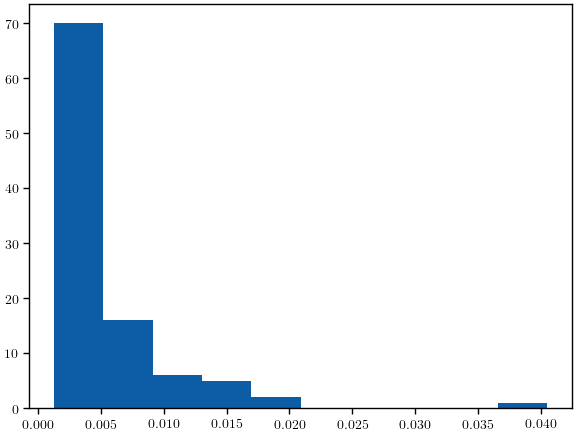

In [16]:
f_sub_list = []

for stats_dict in stats_list:
    effective_lensing_mass = stats_dict['effective_lensing_mass']
    total_mass_subhalos_within_einstein_radius = stats_dict['total_mass_subhalos_within_einstein_radius']
    f_sub = total_mass_subhalos_within_einstein_radius / effective_lensing_mass
    f_sub_list.append(f_sub)

plt.hist(f_sub_list, bins=int(np.sqrt(num_realizations)))
plt.show()

In [17]:
realization_list = [l.realization for l in lens_list]

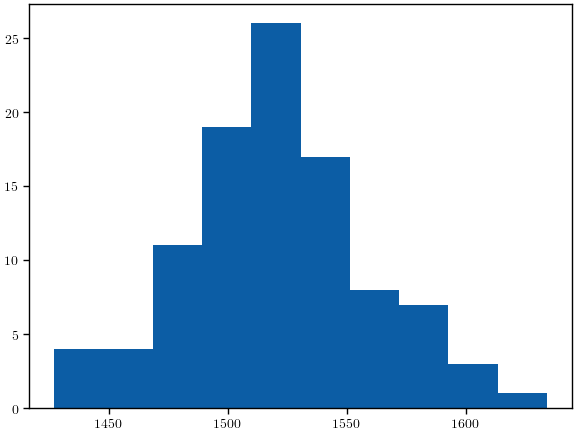

In [18]:
subhalo_count = [len(r.halos) for r in realization_list]

plt.hist(subhalo_count, bins=int(np.sqrt(num_realizations)))
plt.show()